<a href="https://colab.research.google.com/github/taliarosenkranz/Marketing_Analysis_Forecasting/blob/main/Bancall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.preprocessing import LabelEncoder

# Importing the dataset

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'title': 'A data-driven approach to predict the success of bank telemarketing'

# Data inspection

In [ ]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN


In [ ]:
y

,y
0,no
1,no
2,no
3,no
4,no
...,...
45206,yes
45207,yes
45208,yes
45209,no


In [ ]:
X.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64

In [ ]:
y.isnull().sum()

y    0
dtype: int64

# Data manipulation

In [ ]:
df = X.merge(y, how='inner', left_index=True, right_index=True)

In [ ]:
df['month'] = df['month'].replace({'may': '05', 'jun': '06', 'jul': '07', 'aug': '08', 'oct': '10', 'nov': '11', 'dec': '12', 'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'sep': '09'})


In [ ]:
df['year']=pd.NA
fill_values = {idx: 2008 if idx < 27728 else (2009 if idx < 42591 else 2010) for idx in df.index}
df['year'] = df['year'].fillna(fill_values)

In [ ]:
df=df.rename(columns={'day_of_week':'day'})

In [ ]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


In [ ]:
date_range = pd.date_range(start='2008-05-05', end='2010-11-11')

# Create a DataFrame with the date range
date_df = pd.DataFrame({'date': date_range})

# Get the day of the week for each date
date_df['day_of_week'] = date_df['date'].dt.day_name()


# Merge the two DataFrames on the 'date' column
df = df.merge(date_df[['date', 'day_of_week']], on='date', how='left')

# Check if the merge was successful
print(df.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day month  duration  campaign  pdays  previous poutcome   y  year  \
0     NaN    5    05       261         1     -1         0      NaN  no  2008   
1     NaN    5    05       151         1     -1         0      NaN  no  2008   
2     NaN    5    05        76         1     -1         0      NaN  no  2008   
3     NaN    5    05        92         1     -1         0      NaN  no  2008   
4     NaN    5    05       198         1     -1         0      NaN  no  2008   

        date day_of_week  
0 2008-05-05      Monday  
1 2008-05-05      Mo

# Data Exploration/Distribution

<ipython-input-65-66a040dc43d1>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 1.0, 'Customer Age Distribution')

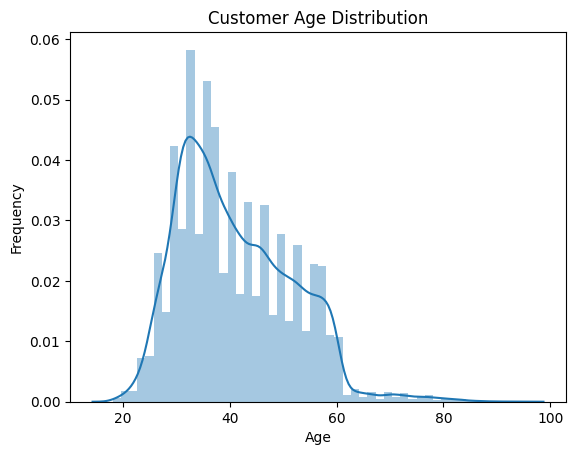

In [ ]:
sns.distplot(df['age'])
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Customer Age Distribution")

Most of the values inside the dataset are distributed between the ages of 30 and 40, then there's a decreese for the following ages.

In [ ]:
job_count = df.job.value_counts()
job_count

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
Name: count, dtype: int64

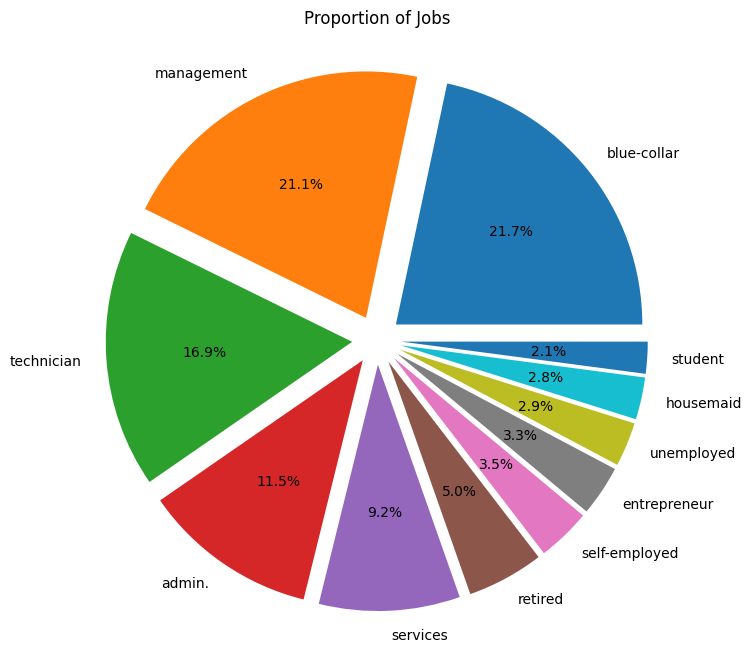

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
explode = [0.1] * len(df['job'].value_counts())
ax.pie(df['job'].value_counts(), labels=df['job'].value_counts().index, autopct='%1.1f%%', explode = explode)
ax.set_title('Proportion of Jobs')
plt.show()

The bisgest percentage of values in the dataset belongs to people that works in the management area, followed by technicians and so on.

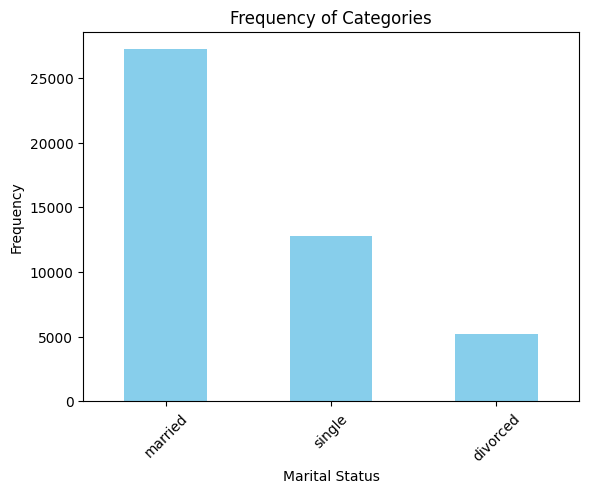

In [ ]:
df['marital'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Frequency of Categories')
plt.xlabel('Marital Status')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Most of the values in the dataset are married

In [ ]:
# Grouping values by different features
demo_seg = df.groupby(["age", "job", "marital","poutcome"])["duration"].mean().reset_index(name="duration_mean")

# Filtering "others" values so to evaluate the poutcome from previous campaigns
demo_seg_no_other = demo_seg[demo_seg["poutcome"]!="other"]

Undersampling the data so to be balanced and to evaluate the poutcome from prevous campaings

In [ ]:
demo_seg

,age,job,marital,poutcome,duration_mean
0,18,student,single,other,298.000000
1,18,student,single,success,151.000000
2,19,student,single,failure,158.333333
3,19,student,single,other,102.666667
4,19,student,single,success,188.400000
...,...,...,...,...,...
1970,86,retired,married,success,219.500000
1971,88,retired,married,failure,161.000000
1972,89,retired,divorced,other,207.000000
1973,92,retired,married,success,164.000000


In [ ]:
fig = px.scatter(demo_seg_no_other, x="age", y="duration_mean", color="poutcome",
                 title="Distribution of Duration Mean by Age and Job",
                 labels={"age": "Age", "duration_mean": "Duration Mean (sec)","job":"Job"},
                 hover_name="marital")

fig.update_layout(xaxis_title="Age", yaxis_title="Duration Mean (sec)")

fig.show()

For the segmented group selected, it is evident that the majority of failures occur in calls with a duration of up to 500 seconds.

However, for individuals aged over 60, the majority of outcomes are successes.

Additionally, there is a higher likelihood of success for calls with an average duration greater than 500 seconds, as indicated by the plot

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




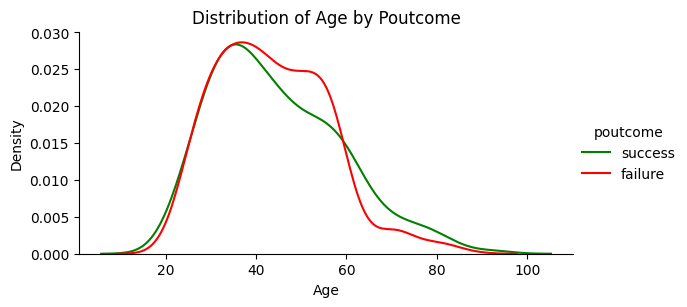

In [ ]:
colors = {'success': 'green', 'failure': 'red'}
g = sns.FacetGrid(demo_seg_no_other, hue="poutcome", palette=colors, aspect=2)

g.map(sns.distplot, 'age', hist=False)
g.add_legend()

plt.title('Distribution of Age by Poutcome')
plt.xlabel('Age')
plt.ylabel('Density')

plt.show()

Building on the previous conclusion, we can identify a specific area for potential improvement within the segmented values, particularly among individuals with more than 60. This age group exhibits a notable proportion of success, suggesting an opportunity for the company to focus its efforts on refining its strategies or tailoring its offerings to better engage and convert customers within this demographic.

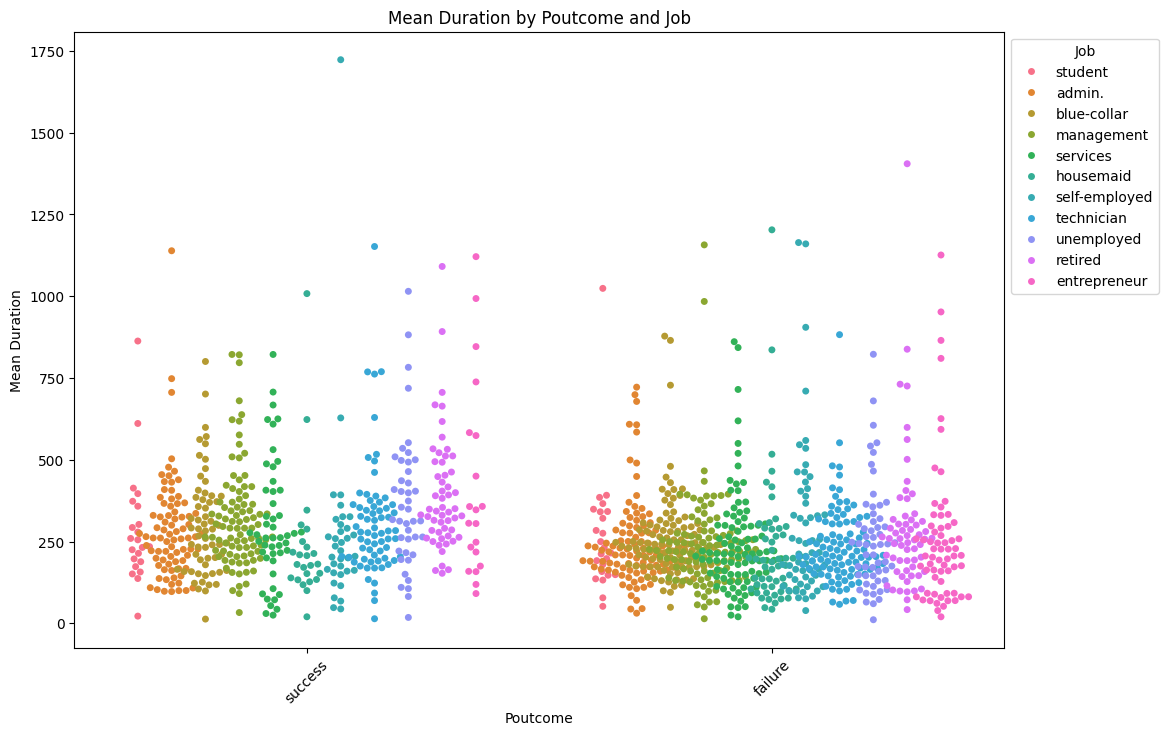

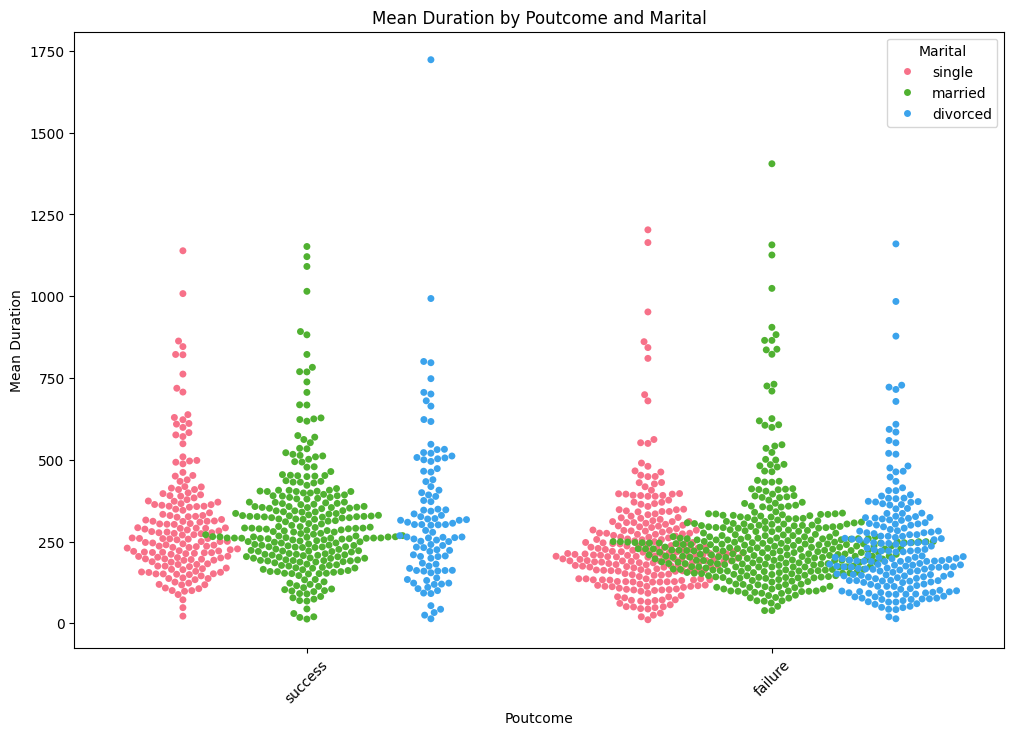

In [ ]:
columns = ['job', 'marital']

for i in columns:
  plt.figure(figsize=(12, 8))
  sns.swarmplot(data=demo_seg_no_other, x='poutcome', y='duration_mean', hue=i, dodge=True, palette='husl')

  plt.title('Mean Duration by Poutcome and ' + i.title())
  plt.xlabel('Poutcome')
  plt.ylabel('Mean Duration')
  plt.legend(title= i.title() , bbox_to_anchor=(1, 1))
  plt.xticks(rotation=45)
  plt.show()


For both features, we observe that successful outcomes from previous campaigns exhibit a higher density for average call durations exceeding 250 seconds. This suggests that longer call durations may be associated with higher success rates, indicating a potential area of focus for future campaigns.

In [ ]:
cdata = df.copy()
cdata = cdata.drop(columns=['contact','y'])
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "day_of_week",'poutcome']
cdata = pd.get_dummies(cdata, columns=categorical_cols, drop_first=False, dtype=int)
cdata = cdata.drop(columns=['poutcome_other'])

<Axes: >

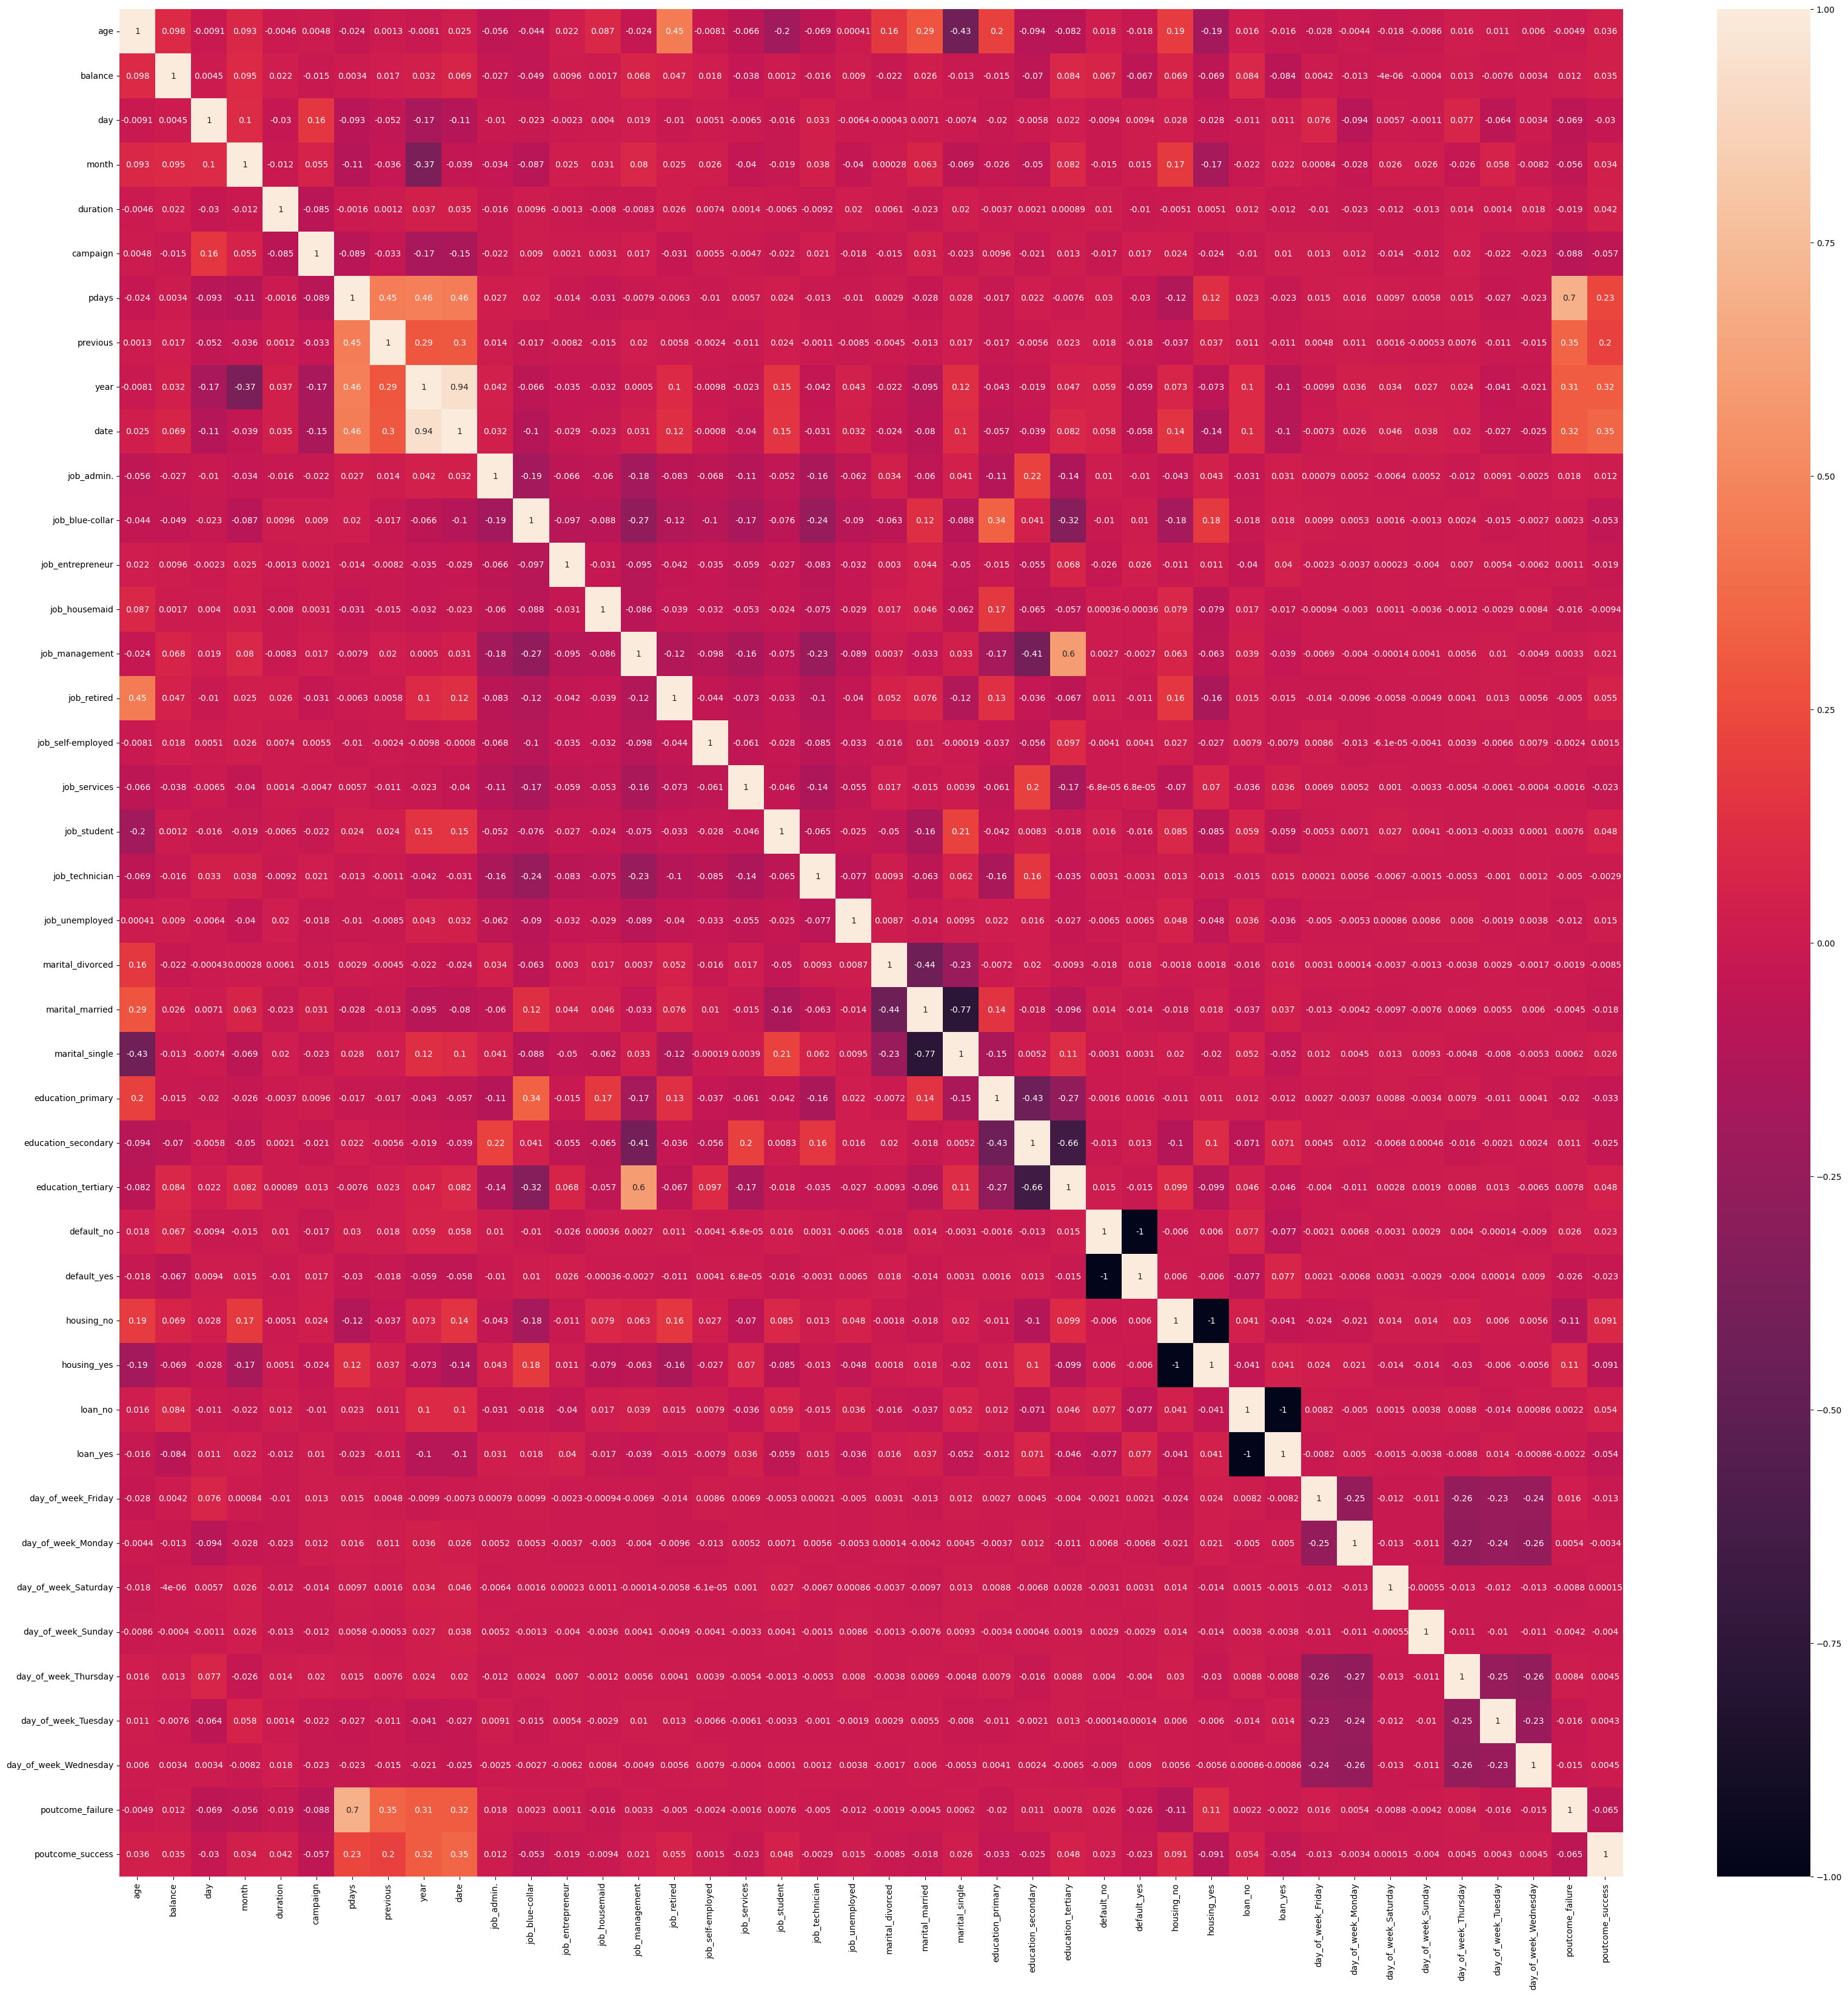

In [ ]:
plt.figure(figsize=(40,40))
sns.heatmap(data=cdata.corr(),annot=True )

There appears to be a noticeable correlation between the number of calls made to a customer (previous) and the success rate. As the number of calls increases, the success rate tends to decrease. Conversely, a longer interval between calls (pdays) is associated with a higher risk of failure.

Furthermore, we can see a strong correlation between the job position from the different customers and their studies, such as blue-collars workers and management.

In [ ]:
X_sorted = X['previous'].value_counts().sort_index()
X_sorted

previous
0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
14        19
15        20
16        13
17        15
18         6
19        11
20         8
21         4
22         6
23         8
24         5
25         4
26         2
27         5
28         2
29         4
30         3
32         1
35         1
37         2
38         2
40         1
41         1
51         1
55         1
58         1
275        1
Name: count, dtype: int64

Most of the values from the dataset are new customers, meaning they  were not contacted before.

# Campaign per day

In [ ]:
df_campaign = df.copy()
df_campaign = df[(df["poutcome"] != "other") & (df["poutcome"] != "ongoing")]

In [ ]:
df_campaign_ = df_campaign.groupby(['day_of_week', 'poutcome'])['poutcome'].count().reset_index(name="outcome_count")
df_campaign_

,day_of_week,poutcome,outcome_count
0,Friday,failure,1033
1,Friday,success,249
2,Monday,failure,1063
3,Monday,success,307
4,Saturday,success,1
5,Sunday,failure,1
6,Thursday,failure,1106
7,Thursday,success,341
8,Tuesday,failure,808
9,Tuesday,success,289


In [ ]:
# Calculate conversion rate for each row
df_campaign_['conversion_rate'] = df_campaign_.apply(lambda row: row['outcome_count'] / df_campaign_[df_campaign_['day_of_week'] == row['day_of_week']]['outcome_count'].sum(), axis=1)
# Dropping Saturday and Sunday values as these are not working days (outliers)
df_campaign_ = df_campaign_[~((df_campaign_['day_of_week'] == 'Saturday') | (df_campaign_['day_of_week'] == 'Sunday'))]

df_campaign_

,day_of_week,poutcome,outcome_count,conversion_rate
0,Friday,failure,1033,0.805772
1,Friday,success,249,0.194228
2,Monday,failure,1063,0.775912
3,Monday,success,307,0.224088
6,Thursday,failure,1106,0.764340
7,Thursday,success,341,0.235660
8,Tuesday,failure,808,0.736554
9,Tuesday,success,289,0.263446
10,Wednesday,failure,882,0.738693
11,Wednesday,success,312,0.261307


we filtered Saturday and Sundays cause these are not working day, representing outliers

In [ ]:
# Define the custom order of days
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Convert the 'day_of_week' column to categorical with the custom order
df_campaign_['day_of_week'] = pd.Categorical(df_campaign_['day_of_week'], categories=days, ordered=True)

# Sort the DataFrame by the 'day_of_week' column
sorted_df_campaign = df_campaign_.sort_values(by='day_of_week')

# Display the sorted DataFrame
print(sorted_df_campaign)


   day_of_week poutcome  outcome_count  conversion_rate
2       Monday  failure           1063         0.775912
3       Monday  success            307         0.224088
8      Tuesday  failure            808         0.736554
9      Tuesday  success            289         0.263446
10   Wednesday  failure            882         0.738693
11   Wednesday  success            312         0.261307
6     Thursday  failure           1106         0.764340
7     Thursday  success            341         0.235660
0       Friday  failure           1033         0.805772
1       Friday  success            249         0.194228


<ipython-input-140-1f59bbd660f3>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



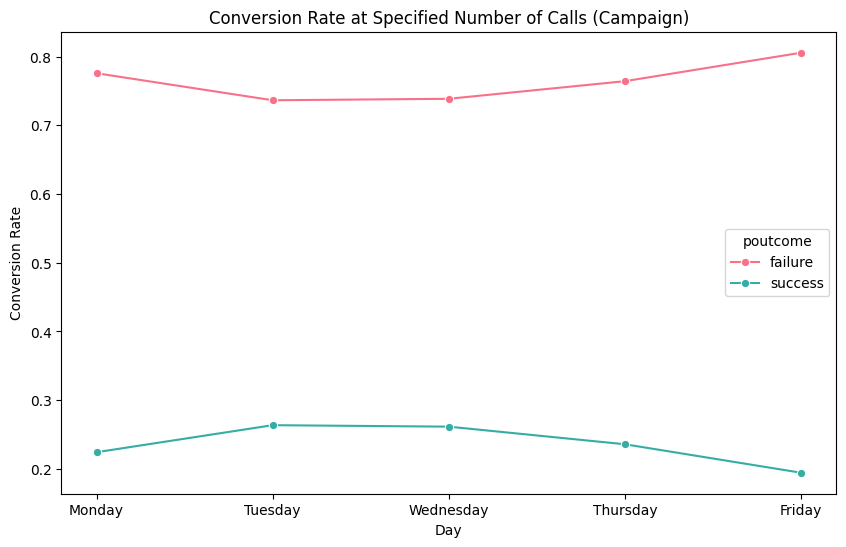

In [ ]:
# Plot conversion rate against campaign
plt.figure(figsize=(10, 6))
sns.lineplot(x='day_of_week', y='conversion_rate', hue='poutcome', data=df_campaign_, marker='o', palette='husl')

# Set title, x-label, and y-label
plt.title('Conversion Rate at Specified Number of Calls (Campaign)')
plt.xlabel('Day')
plt.ylabel('Conversion Rate')

# Show the plot
plt.show()

We can appreciate here that the days with the highest success rate are Tuesdays and Fridays are the ones with the less.